================================================================================
Poisson Equation Solver using Firedrake FEM-CG
================================================================================

SUMMARY:
--------
This script solves the 2D Poisson equation:
    -∇²u = f(x,y)
on the unit square [0,1]×[0,1] with:
    - Homogeneous Dirichlet BCs at x=0 and x=1: u(0,y) = u(1,y) = 0
    - Homogeneous Neumann BCs at y=0 and y=1 (natural BCs, automatically satisfied)
    - Source term: f(x,y) = 2π² sin(πx) cos(πy)
    - Exact solution: u(x,y) = sin(πx) cos(πy)

METHODS:
--------
1. Method 1: Manual weak form construction
   - Constructs bilinear form a(u,v) and linear form L(v) explicitly
   - Solves the resulting linear system directly

2. Method 2: Variational principle via derivative
   - Defines the Ritz-Galerkin functional J[u]
   - Generates weak form F via automatic differentiation
   - Solves the resulting nonlinear system (which is linear for Poisson)

CONTENTS:
---------
1. Mesh generation (quadrilateral elements)
2. Function space definition (CG1 - piecewise linear continuous Galerkin)
3. Method 1: Direct weak form solve
4. Method 2: Variational principle solve
5. Post-processing: VTK output and L2 error computation

OUTPUT:
-------
- output.pvd: ParaView file containing both solutions (u_1, u_2)
- Console: L2 errors for each method and difference between methods

USAGE:
------
Run with: python3 Poissons_eq_v2.py
View with: paraview output.pvd

================================================================================


In [ ]:
from firedrake import *

In [25]:
# 1. MESH GENERATION
# ==============================================================================

# Mesh resolution: number of elements in x and y directions
nx = ny = 128  # Try various mesh resolutions, starting coarse (e.g., 16x16)

# Create a structured quadrilateral mesh on the unit square [0,1]×[0,1]
mesh = UnitSquareMesh(nx, ny, quadrilateral=True)
# Reference: https://www.firedrakeproject.org/firedrake.html#firedrake.utility_meshes.UnitSquareMesh
# Alternatively, use gmsh for more complex geometries


In [26]:
# ==============================================================================
# 2. FUNCTION SPACE DEFINITION
# ==============================================================================

# Define piecewise linear continuous Galerkin (CG1) function space
# This means polynomials of degree 1 that are continuous across element boundaries
V = FunctionSpace(mesh, 'CG', 1)
# Reference: https://www.firedrakeproject.org/variational-problems.html
# Defines the discretisation used for all the functions within the space V.
# Consider some function h defined on the unit square smooth, continuous. There exists some map, 
# interpolation?, to a function h_h in V such that h_h approximates h with a number of 
# linear functions in each element of the mesh.

In [27]:
# ==============================================================================
# 3. METHOD 1: MANUAL WEAK FORM CONSTRUCTION
# ==============================================================================
# 
# Weak formulation of -∇²u = f:
#   ∫ ∇u·∇v dx = ∫ f·v dx  for all test functions v
#
# This is obtained by multiplying the PDE by a test function v,
# integrating over the domain, and applying integration by parts.
# Finding the solution u that satisfies a = L for all v in the function space V.

# Define trial function (the unknown u) and test function (v) from the function space V
u = TrialFunction(V)  # The unknown function u(x,y) to be solved for
v = TestFunction(V)   # The test function v(x,y) (also called δu or variation)

# Get mesh coordinates for defining the source term
x, y = SpatialCoordinate(mesh)

# Define the source term f(x,y) = 2π² sin(πx) cos(πy) from the function space V 
# a respresentation of the exact soln
# This is chosen so the exact solution is u(x,y) = sin(πx) cos(πy)
# Since -∇²(sin(πx)cos(πy)) = 2π² sin(πx) cos(πy)
f = Function(V).interpolate(2*pi**2*sin(pi*x)*cos(pi*y))

# Bilinear form: a(u,v) = ∫ ∇u·∇v dx
# This represents the left-hand side of the weak form
a = (inner(grad(u), grad(v)))*dx

# Linear form: L(v) = ∫ f·v dx
# This represents the right-hand side of the weak form
# dx represents the infinitesimal area element dx·dy
L = (f*v)*dx

# Create a Function to hold the solution from Method 1
u_1 = Function(V, name='u_1')

# Define Dirichlet boundary conditions
# bc_x0: u = 0 on the boundary at x=0 (boundary ID 1)
bc_x0 = DirichletBC(V, Constant(0), 1)
# bc_x1: u = 0 on the boundary at x=1 (boundary ID 2)
bc_x1 = DirichletBC(V, Constant(0), 2)
# Reference: https://www.firedrakeproject.org/firedrake.html#firedrake.bcs.DirichletBC
# Note: Homogeneous Neumann BCs (∂u/∂n = 0 at y=0,1) are natural boundary conditions
#       and are automatically satisfied in the weak form (no explicit implementation needed)

# Solve the linear system a(u,v) = L(v) subject to boundary conditions
# Solver parameters:
#   - ksp_type='cg': Use Conjugate Gradient iterative solver
#   - pc_type='none': No preconditioner (for demonstration; in practice use preconditioners)
solve(a == L, u_1, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'}, bcs=[bc_x0, bc_x1])


In [28]:
# ==============================================================================
# 4. METHOD 2: VARIATIONAL PRINCIPLE VIA DERIVATIVE
# ==============================================================================
#
# Alternatively, we can define the Ritz-Galerkin functional (energy functional):
#   J[u] = ∫ (½|∇u|² - fu) dx
#
# The solution minimizes this functional. Taking the first variation (derivative)
# with respect to u gives the weak form automatically.
# Finding the minimal point of J[u] by finding where the derivative is 0 numerically given the variation 
# is v.

# Create a Function to hold the solution from Method 2
u_2 = Function(V, name='u_2')

# Define the Ritz-Galerkin functional J[u]
# J[u] = ∫ (½ ∇u·∇u - u·f) dx
# The minimizer of J[u] satisfies -∇²u = f
Ju = (0.5*inner(grad(u_2), grad(u_2)) - u_2*f)*dx

# Compute the first variation (Gateaux derivative) of J with respect to u_2
# in the direction of the test function v
# This automatically generates the weak form: F(u,v) = 0
F = derivative(Ju, u_2, du=v)

# Solve the nonlinear system F(u,v) = 0 subject to boundary conditions
# (For the Poisson equation, this is actually linear, but the solver handles it as nonlinear)
solve(F == 0, u_2, bcs=[bc_x0, bc_x1])


In [29]:
# ==============================================================================
# 5. POST-PROCESSING
# ==============================================================================

# Write solutions to ParaView-compatible VTK file for visualization
# Reference: https://www.firedrakeproject.org/visualisation.html#creating-output-files
outfile = VTKFile('output.pvd')
outfile.write(u_1, u_2)

# Compute L2 errors by comparing with the exact solution
# Exact solution: u_exact(x,y) = sin(πx) cos(πy)
# Define new function to hold exact solution
exact = Function(V).interpolate(sin(pi*x)*cos(pi*y))

# L2 error for Method 1: ||u_1 - u_exact||_L2
# L2 norm is: ||w||_L2 = sqrt(∫ w² dx)
L2_1 = sqrt(assemble(dot(u_1 - exact, u_1 - exact) * dx))

# L2 error for Method 2: ||u_2 - u_exact||_L2
L2_2 = sqrt(assemble(dot(u_2 - f, u_2 - f) * dx))

# L2 norm of difference between the two methods: ||u_2 - u_1||_L2
# This should be near machine precision since both methods solve the same problem
L2 = sqrt(assemble(dot(u_2 - u_1, u_2 - u_1) * dx))

# Print results to console
print(f'Mesh resolution: Δx = {1/nx}')
print(f'L2 error: Method1 = {L2_1}, Method2 = {L2_2}')
print(f'L2 norm between the two results: {L2}')

# ==============================================================================
# END OF SCRIPT
# ==============================================================================

Mesh resolution: Δx = 0.0078125
L2 error: Method1 = 2.5096426249681793e-05, Method2 = 9.368688847625856
L2 norm between the two results: 1.0718111218314011e-13


##

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance
/home/alex/Numerics/.venv/lib/python3.12/site-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/home/alex/Numerics/.venv/lib/python3.12/site-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


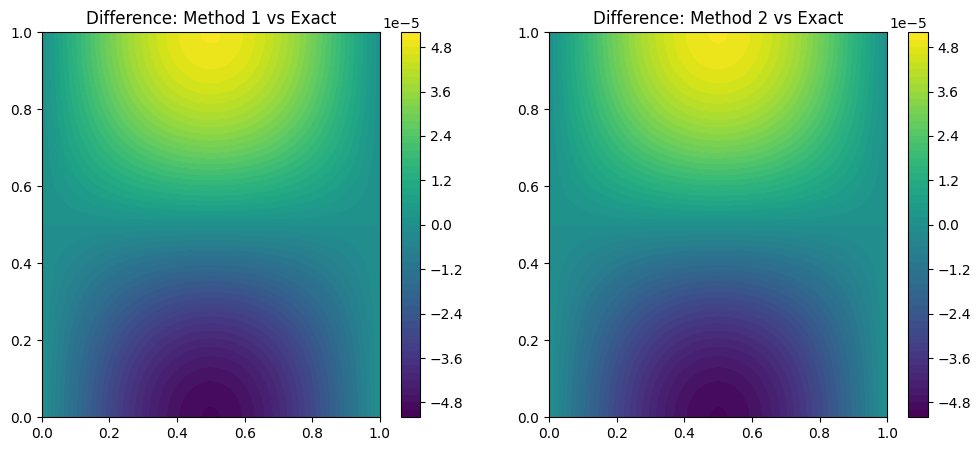

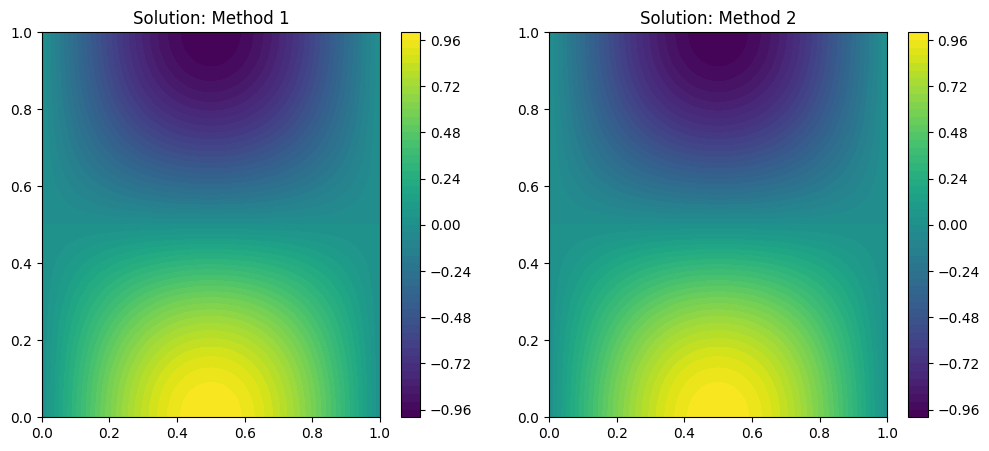

{'L2_error_method1': 2.5096426249681793e-05,
 'L2_error_method2': 2.5096426356840165e-05,
 'L2_norm_between_methods': 1.0718111218314011e-13}

In [1]:
# Solving function that allows the input of the mesh resolution dx and the polynomial degree p. Output the 
# result to a file and return the L2 errors.

from firedrake import *
def solve_poisson(delta_x: float, p: int, show: bool = False) -> dict:
    # 1: Mesh Generation
    nx = ny = int(1/delta_x)
    mesh = UnitSquareMesh(nx, ny, quadrilateral=True)

    # 2. Function Space Definition
    V = FunctionSpace(mesh, 'CG', p)

    u = TrialFunction(V)
    v = TestFunction(V)
    x, y = SpatialCoordinate(mesh)

    # Boundary Conditions
    bc_x0 = DirichletBC(V, Constant(0), 1)
    bc_x1 = DirichletBC(V, Constant(0), 2)


    # 3. Weak Form Construction
    u_1 = Function(V, name='u_1')
    f = Function(V).interpolate(2*pi**2*sin(pi*x)*cos(pi*y))
    a = (inner(grad(u), grad(v)))*dx
    L = (f*v)*dx
    solve(a == L, u_1, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'}, bcs=[bc_x0, bc_x1])

    # 4. Variational Principle
    u_2 = Function(V, name='u_2')
    Ju = (0.5*inner(grad(u_2), grad(u_2)) - u_2*f)*dx
    F = derivative(Ju, u_2, du=v)
    solve(F == 0, u_2, bcs=[bc_x0, bc_x1])

    # 5. Post-procesing
    exact = Function(V).interpolate(sin(pi*x)*cos(pi*y))

    # Define the difference function between the exact and weak form solutions
    diff_1 = Function(V, name='diff_1')
    diff_1.interpolate(u_1 - exact)
    diff_2 = Function(V, name='diff_2')
    diff_2.interpolate(u_2 - exact)

    # Output 
    # outfile = VTKFile('output_dx{}_p{}.pvd'.format(dx, p))
    # outfile.write(u_1, u_2)

    L2_1 = sqrt(assemble(dot(u_1 - exact, u_1 - exact) * dx))
    L2_2 = sqrt(assemble(dot(u_2 - exact, u_2 - exact) * dx))
    L2 = sqrt(assemble(dot(u_2 - u_1, u_2 - u_1) * dx))
    
    result: dict = {
        'L2_error_method1': L2_1,
        'L2_error_method2': L2_2,
        'L2_norm_between_methods': L2
    }

    if show:
        import matplotlib.pyplot as plt
        # Plot a contour of the difference functions
        ys = np.linspace(0, 1, ny+1)
        xs = np.linspace(0, 1, nx+1)
        diff_1_vals = [diff_1.at([x, y]) for y in ys for x in xs]
        diff_2_vals = [diff_2.at([x, y]) for y in ys for x in xs]

        X, Y = np.meshgrid(xs, ys)
        Z1 = np.array(diff_1_vals).reshape((ny+1, nx+1))
        Z2 = np.array(diff_2_vals).reshape((ny+1, nx+1))
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.contourf(X, Y, Z1, levels=50, cmap='viridis')
        plt.colorbar()
        plt.title('Difference: Method 1 vs Exact')
        plt.subplot(1, 2, 2)
        plt.contourf(X, Y, Z2, levels=50, cmap='viridis')
        plt.colorbar()
        plt.title('Difference: Method 2 vs Exact')
        plt.show()  

        # Plot contours of the solutions
        u_1_vals = [u_1.at([x, y]) for y in ys for x in xs]
        u_2_vals = [u_2.at([x, y]) for y in ys for x in xs]
        Z1 = np.array(u_1_vals).reshape((ny+1, nx+1))
        Z2 = np.array(u_2_vals).reshape((ny+1, nx+1))
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.contourf(X, Y, Z1, levels=50, cmap='viridis')
        plt.colorbar()
        plt.title('Solution: Method 1')
        plt.subplot(1, 2, 2)
        plt.contourf(X, Y, Z2, levels=50, cmap='viridis')
        plt.colorbar()
        plt.title('Solution: Method 2')
        plt.show()

    return result

# Test with p=1 and dx=1/128
results = solve_poisson(1/128, 1, show=True)
results

In [2]:
dxs = [1/2 ** i for i in range(2, 8)]  # Mesh sizes
ps = [1, 2, 3, 4]

results = {}
for delta_x in dxs:
    for p in ps:
        print(f'Beginning dx={delta_x}, nx={int(1/delta_x)} p={p}')
        results[(delta_x, p)] = solve_poisson(delta_x, p)
        print(f'Completed dx={dx}, p={p}')
        print('-----------------------')


 
# Matrix print just the method 1 errors for each (dx, p)
for p in ps:
    print(f'Polynomial degree p={p}:')
    for delta_x in dxs:
        err = results[(delta_x, p)]['L2_error_method1']
        print(f'  dx={delta_x:.5f}, L2 error (Method 1)={err:.5e}')

Beginning dx=0.25, nx=4 p=1
Completed dx=dx(subdomain_id=everywhere), p=1
-----------------------
Beginning dx=0.25, nx=4 p=2
Completed dx=dx(subdomain_id=everywhere), p=2
-----------------------
Beginning dx=0.25, nx=4 p=3
Completed dx=dx(subdomain_id=everywhere), p=3
-----------------------
Beginning dx=0.25, nx=4 p=4
Completed dx=dx(subdomain_id=everywhere), p=4
-----------------------
Beginning dx=0.125, nx=8 p=1
Completed dx=dx(subdomain_id=everywhere), p=1
-----------------------
Beginning dx=0.125, nx=8 p=2
Completed dx=dx(subdomain_id=everywhere), p=2
-----------------------
Beginning dx=0.125, nx=8 p=3
Completed dx=dx(subdomain_id=everywhere), p=3
-----------------------
Beginning dx=0.125, nx=8 p=4
Completed dx=dx(subdomain_id=everywhere), p=4
-----------------------
Beginning dx=0.0625, nx=16 p=1
Completed dx=dx(subdomain_id=everywhere), p=1
-----------------------
Beginning dx=0.0625, nx=16 p=2
Completed dx=dx(subdomain_id=everywhere), p=2
-----------------------
Beginning 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# L2 Error Plot from the above
def l2_error(dxs, errors: list[list[float]], names: list[str]):
    dxs_squared = [delta_x**2 for delta_x in dxs]
    
    plt.figure(num=1)
    plt.loglog(dxs, dxs_squared, 'k--', label='$(\Delta x)^2$')
    for err, name in zip(errors, names):
        plt.loglog(dxs, err, marker='o', label=name)

    plt.xlabel('$\Delta x$',fontsize=14)
    plt.ylabel('$L^2$ error',fontsize=14)
    plt.grid()
    plt.legend(prop={'size':14})
    plt.tight_layout()
    plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_404049/4136148608.py:9: SyntaxWarning: invalid escape sequence '\D'
  plt.loglog(dxs, dxs_squared, 'k--', label='$(\Delta x)^2$')
/tmp/ipykernel_404049/4136148608.py:13: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta x$',fontsize=14)


Polynomial degree p=1:
  dx=0.25000, L2 error (Method 1)=2.24596e-02
  dx=0.12500, L2 error (Method 1)=6.21390e-03
  dx=0.06250, L2 error (Method 1)=1.59301e-03
  dx=0.03125, L2 error (Method 1)=4.00757e-04
  dx=0.01562, L2 error (Method 1)=1.00346e-04
  dx=0.00781, L2 error (Method 1)=2.50964e-05
Polynomial degree p=2:
  dx=0.25000, L2 error (Method 1)=2.58127e-04
  dx=0.12500, L2 error (Method 1)=1.65739e-05
  dx=0.06250, L2 error (Method 1)=1.04273e-06
  dx=0.03125, L2 error (Method 1)=6.52773e-08
  dx=0.01562, L2 error (Method 1)=4.08159e-09
  dx=0.00781, L2 error (Method 1)=2.55484e-10
Polynomial degree p=3:
  dx=0.25000, L2 error (Method 1)=3.30261e-06
  dx=0.12500, L2 error (Method 1)=1.07043e-07
  dx=0.06250, L2 error (Method 1)=3.38214e-09
  dx=0.03125, L2 error (Method 1)=1.06439e-10
  dx=0.01562, L2 error (Method 1)=5.33964e-12
  dx=0.00781, L2 error (Method 1)=2.17148e-12
Polynomial degree p=4:
  dx=0.25000, L2 error (Method 1)=1.07841e-07
  dx=0.12500, L2 error (Method 1)=

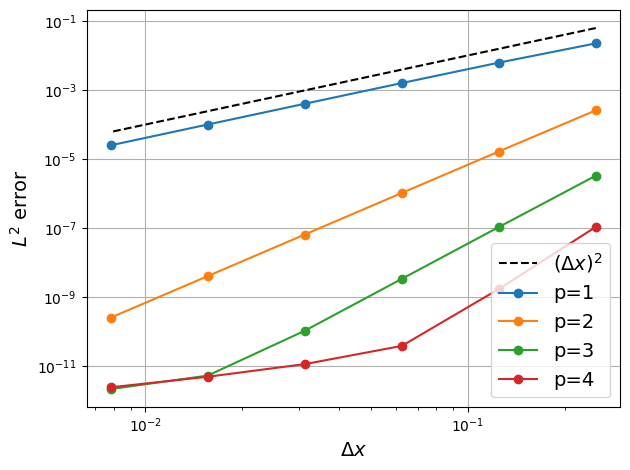

In [4]:
# Matrix print just the method 1 errors for each (dx, p)
matrix = [[] for p in ps]
index = -1
for p in ps:
    index += 1
    print(f'Polynomial degree p={p}:')
    for delta_x in dxs:
        err = results[(delta_x, p)]['L2_error_method1']
        print(f'  dx={delta_x:.5f}, L2 error (Method 1)={err:.5e}')
        matrix[index].append(err)

for line in matrix:
    print('  '.join(f'{val:.5e}' for val in line))

dxs = [1/2 ** i for i in range(2, 8)]  # Mesh sizes
l2_error(dxs, matrix, [f'p={p}' for p in ps])

Doubling the resolution (Quadruple elements) will quarter the error.

(1,4) (2,1)

(1,5) (2,2)

(2,3) (3,1)

(2,4) (3,2)

(2,5) (3,3)

(2,6) (3,4)*

# Different Function

In [34]:
exact = Function(V).interpolate(sin(pi*x) * y**2 * (2*y -3))
f = Function(V).interpolate(-(-pi**2 * y**2 * (2*y -3) + 6*(2*y - 1) * sin(pi*x)))

# Weak form
u_secondary_1 = Function(V, name='u_secondary_1')
a = (inner(grad(u), grad(v)))*dx
L = (f*v)*dx
solve(a == L, u_secondary_1, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'}, bcs=[bc_x0, bc_x1])

# Variational
u_secondary_2 = Function(V, name='u_secondary_2')
Ju = (0.5*inner(grad(u_secondary_2), grad(u_secondary_2)) - u_secondary_2*f)*dx
F = derivative(Ju, u_secondary_2, du=v)
solve(F == 0, u_secondary_2, bcs=[bc_x0, bc_x1])

L2_secondary_1 = sqrt(assemble(dot(u_secondary_1 - exact, u_secondary_1 - exact) * dx))
L2_secondary_2 = sqrt(assemble(dot(u_secondary_2 - exact, u_secondary_2 - exact) * dx))
print(f'Secondary Test L2 Errors: Method 1 = {L2_secondary_1}, Method 2 = {L2_secondary_2}')


Secondary Test L2 Errors: Method 1 = 0.10427581895113636, Method 2 = 0.10427581896759916


/home/alex/Numerics/.venv/lib/python3.12/site-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


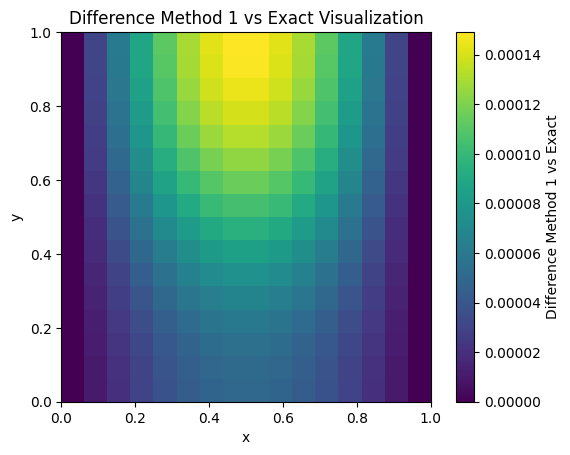

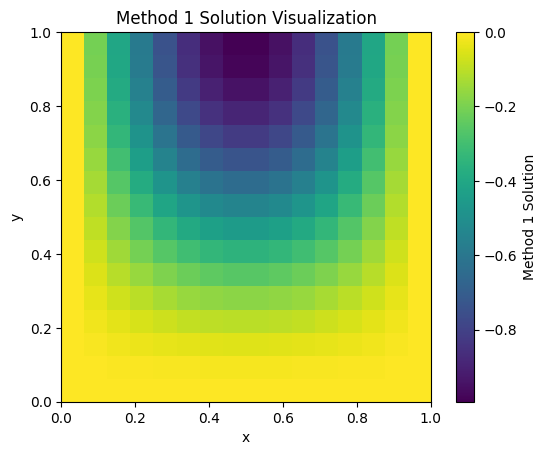

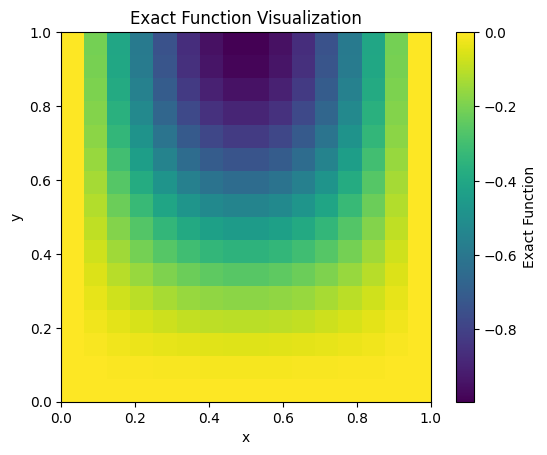

In [35]:
def plotter(func: Function, title: str, n: int = 10):
    import matplotlib.pyplot as plt
    import numpy as np

    xs = np.linspace(0, 1, n)
    ys = np.linspace(0, 1, n)
    values = np.array([[func.at(xi, yi) for xi in xs] for yi in ys])
    plt.imshow(values, extent=(0, 1, 0, 1), origin='lower')
    plt.colorbar(label=title)
    plt.title(f'{title} Visualization')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Solver with parameters for dx, p, f and exact
def solver_poisson_additional(delta_x: float, p: int, f_expr, exact_expr) -> dict:
    # 1: Mesh Generation
    nx = ny = int(1/delta_x)
    mesh = UnitSquareMesh(nx, ny, quadrilateral=True)

    # 2. Function Space Definition
    V = FunctionSpace(mesh, 'CG', p)

    u = TrialFunction(V)
    v = TestFunction(V)
    x, y = SpatialCoordinate(mesh)

    # Boundary Conditions
    bc_x0 = DirichletBC(V, Constant(0), 1)
    bc_x1 = DirichletBC(V, Constant(0), 2)


    # 3. Weak Form Construction
    u_1 = Function(V, name='u_1')
    f = Function(V).interpolate(f_expr)
    a = (inner(grad(u), grad(v)))*dx
    L = (f*v)*dx
    solve(a == L, u_1, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'}, bcs=[bc_x0, bc_x1])

    # 4. Variational Principle
    u_2 = Function(V, name='u_2')
    Ju = (0.5*inner(grad(u_2), grad(u_2)) - u_2*f)*dx
    F = derivative(Ju, u_2, du=v)
    solve(F == 0, u_2, bcs=[bc_x0, bc_x1])

    # 5. Post-procesing
    exact = Function(V).interpolate(exact_expr)

    # Define the difference function between the exact and weak form solutions
    diff_1 = Function(V, name='diff_1')
    diff_1.interpolate(u_1 - exact)
    diff_2 = Function(V, name='diff_2')
    diff_2.interpolate(u_2 - exact)

    # Output 
    outfile = VTKFile('output_dx{}_p{}.pvd'.format(delta_x, p))
    outfile.write(u_1, u_2, diff_1, diff_2)

    L2_1 = sqrt(assemble(dot(u_1 - exact, u_1 - exact) * dx))
    L2_2 = sqrt(assemble(dot(u_2 - exact, u_2 - exact) * dx))
    L2 = sqrt(assemble(dot(u_2 - u_1, u_2 - u_1) * dx))
    result: dict = {
        'L2_error_method1': L2_1,
        'L2_error_method2': L2_2,
        'L2_norm_between_methods': L2
    }

    # Show the difference function
    plotter(diff_1, "Difference Method 1 vs Exact", n=16)

    # Show u_1 
    plotter(u_1, "Method 1 Solution", n=16)

    # Show exact
    plotter(exact, "Exact Function", n=16)
    

    return result
# Test with p=2 and dx=1/64
exact = Function(V).interpolate(sin(pi*x) * y**2 * (2*y -3))
f = Function(V).interpolate(-1 * (-1 * pi**2*y**2*(2*y -3) + 6*(2*y - 1)) * sin(pi*x))
results = solver_poisson_additional(1/64, 1, f, exact)

In [36]:
results

{'L2_error_method1': 7.515309751257136e-05,
 'L2_error_method2': 7.515309755559411e-05,
 'L2_norm_between_methods': 4.304447154966511e-14}

In [37]:
# Test output
v = Function(V, name='v')
v.interpolate(sin(pi*x) * cos(pi*y))

outfile = VTKFile('output_test.pvd')
outfile.write(v)

/home/alex/Numerics/.venv/lib/python3.12/site-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/home/alex/Numerics/.venv/lib/python3.12/site-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


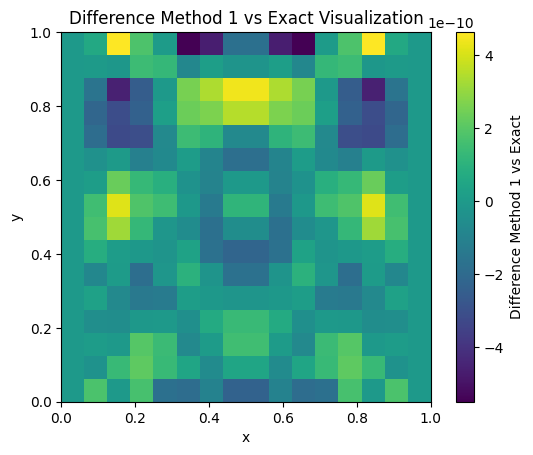

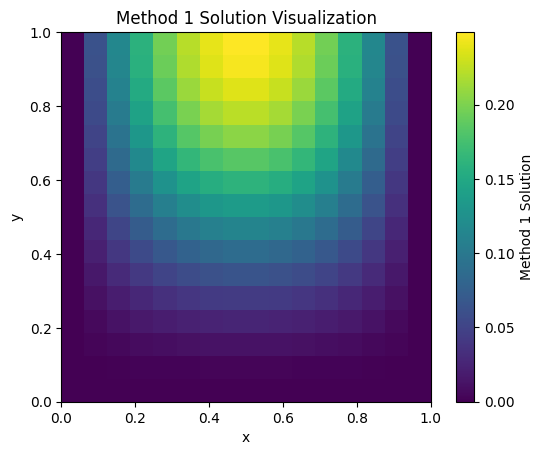

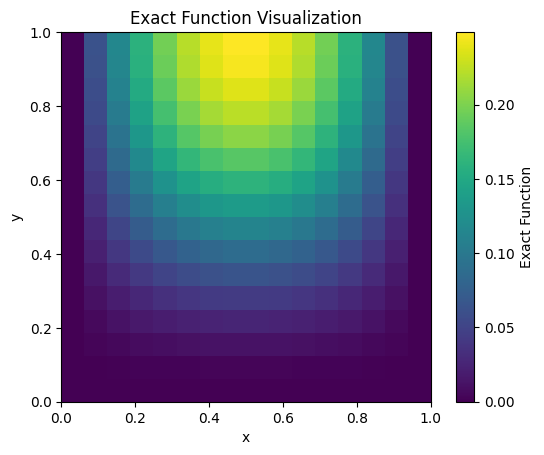

{'L2_error_method1': 1.613808867001115e-10,
 'L2_error_method2': 7.748796532524971e-16,
 'L2_norm_between_methods': 1.6138093193403856e-10}

In [38]:
exact = Function(V).interpolate(x * (x-1) * y**2 * (2*y -3))
f = Function(V).interpolate(-1 * (2*(2*y**3 - 3*y**2) + 6*(2*y-1) *(x*(x-1))))
results = solver_poisson_additional(1/8, 2, f, exact)
results

<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:25: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:25: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_378186/567448281.py:23: SyntaxWarning: invalid escape sequence '\D'
  plt.loglog(dx,ref,'g:',label='$(\Delta x)^2$')
/tmp/ipykernel_378186/567448281.py:25: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta x$',fontsize=14)


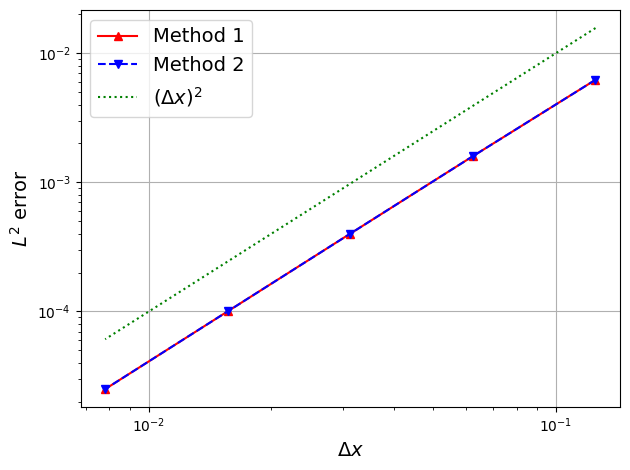

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dxs=[1/8,1/16,1/32,1/64,1/128]
# Method 1:
L2_1=[0.006213900940245384,
	  0.001593010773101212,
	  0.00040075733646107597,
	  0.0001003464039782477,
	  2.5096426072489425e-05]
# Method 2:
L2_2=[0.006213900940245383,
	  0.0015930107731022762,
	  0.0004007573364659739,
	  0.00010034640400416159,
	  2.509642615825676e-05]
ref=[ele**2 for ele in dxs]

plt.figure(num=1)

plt.loglog(dxs,L2_1,'^r-',label='Method 1')
plt.loglog(dxs,L2_2,'vb--',label='Method 2')
plt.loglog(dxs,ref,'g:',label='$(\Delta x)^2$')
plt.grid()
plt.xlabel('$\Delta x$',fontsize=14)
plt.ylabel('$L^2$ error',fontsize=14)
plt.legend(prop={'size':14})
plt.tight_layout()

plt.show()